## 6481784 - Group 7 Individual Experimentation



This report details the results of the experimentation performed by myself, for the benefit of Group 7's COM3029 Group Coursework. 

The aim of our project is to produce a model that can predict whether a given text contains obscenities, toxicity, identity hate, insults, or threats. This model may then be fed samples, and the resulting prediction could be used to automatically flag comments for the benefit of moderators of online communities in any context.

The dataset chosen for this purpose was obtained on Kaggle [https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge], which has been scraped by the Conversation AI team [https://conversationai.github.io/]. It is comprised of comments from Wikipedia's talk page edits. It should be noted that the contents of some of the comments are offensive.

### Experimentation Goal

My part of the experimentation on the project mostly focuses on optimising the choice of different hyperparameters for the model itself. It should be noted that these experiments will be performed on the Base Model. Another groupmate, Vinal Asodia, will be performing 2 similar setups on an LSTM model, however both of our experiments are worth performing as they are performed on completely separate models.

Nevertheless, I have not omitted any aspect of the dataset visualisation, pre-processing, or results evaluation. Please be aware, however, that the above is the case for my groupmates as well, and much of the code was developed in cooperation with each other. 

For this reason, it will be called out where the code used was originally produced by one of my groupmates.

### Initial Library Imports

In [1]:
# Imports
import pickle
import keras
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, GlobalMaxPooling1D, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Pre-processing imports
import functools
import nltk

from functools import lru_cache
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Constants
EPOCHS = 15
INIT_LR = 1e-3
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

### Import dataset

The dataset was obtained in the form of 3 .csv files: *train.csv*, *test.csv*, and *test_labels.csv*. The format of these files is mostly shared. 

Broadly speaking, each row contains a column named *comment_text* containing the exact text of the scraped comment, the length of which may be a few characters or many paragraphs. Each row has also labelled by human raters with a value of 0 or 1 in each of the following categories, per the type of toxicity it contains, in this order:

*   *toxic*
*   *severe_toxic*
*   *obscene*
*   *threat*
*   *insult*
*   *identity_hate*

More specifically, *train.csv* contains 159572 comments, all labelled in the 6 categories above, and all are also provided with an *id* value, that is not used in the scope of this project. *test.csv* contains only the text contents of 153165 additional comments, while *test_labels.csv* only contains the labels of the same set of comments. 

In [2]:
# Read datasets into DataFrame format
train = pd.read_csv("data/train.csv")
test_data = pd.read_csv("data/test.csv")
test_labels = pd.read_csv("data/test_labels.csv")

# Remove rows NaN and inf values 
train = train.dropna()

test = pd.concat([test_data, test_labels], axis=1)

# id column is unused and thus removed
train = train.drop(columns=["id"])
test = test.drop(columns=["id"])

As this project does not require unlabelled data, the initially separated *test.csv* data and the matching *test_labels.csv* labels are combined into one DataFrame.

In the now-concatenated *test* DataFrame, certain rows were not rated, and thus were labelled with a -1 value in every column. For the reason described above, these rows are dropped in the cell below.

In [3]:
test = test.drop(test[(test.toxic == -1) |
                      (test.severe_toxic == -1) |
                      (test.obscene == -1) |
                      (test.threat == -1) |
                      (test.insult == -1) |
                      (test.identity_hate == -1)].index)

### Preliminary Visualisation

These visualisations were prepared by Vinal Asodia

In [4]:
# Gather all samples that have no toxic labels, these can be consider "non-toxic"
non_toxic = train[(train.toxic == 0) &
                  (train.severe_toxic == 0) & 
                  (train.obscene == 0) & 
                  (train.threat == 0) & 
                  (train.insult == 0) & 
                  (train.identity_hate == 0)]

# Gather all samples that are labelled
toxic = train[(train.toxic == 1) |
                  (train.severe_toxic == 1) | 
                  (train.obscene == 1) | 
                  (train.threat == 1) | 
                  (train.insult == 1) | 
                  (train.identity_hate == 1)]

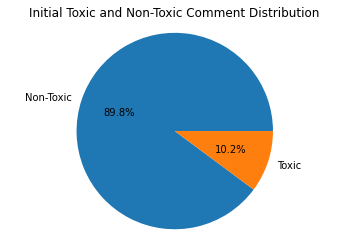

In [5]:
labels = ["Non-Toxic", "Toxic"]
data = [len(non_toxic), len(toxic)]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Initial Toxic and Non-Toxic Comment Distribution')
plt.axis('equal')
plt.show()

As can be seen above, of the 159572 comments in *train.csv* ~90% are rated as not containing any of the relevant types of toxicity. Preliminary experiments have shown that training a model with this class balancing results in a model that tends to predict all comments are non-toxic.

In [6]:
classes = {}

for index in range(1,7):
    classes.update({train.iloc[:,index].name : np.histogram(train.iloc[:,index], bins=2)[0]})

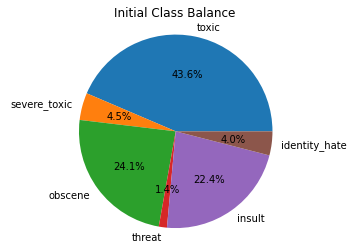

In [7]:
labels = list(classes.keys())
values = list(classes.values())
data = [values[x][1] for x in range(0,len(values))]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Initial Class Balance')
plt.axis('equal')
plt.show()

As well as being mostly comprised of non-toxic comments, the toxic population of comments is also heavily skewed towards comments rated as *toxic*. While this is understandable, as it is more common than not for obscene comments to also be toxic, for example, this has also been found to hurt the performance of the model on the full spectrum of comments in the dataset.

For this reason, as well as the reason outlined above, many of the rows in these most populous groups are dropped, to increase the variety of the dataset, as well as reduce the amount of resources needed to train the model.

In [8]:
train = train.drop(train[(train.toxic == 1) & (train.severe_toxic != 1) & (train.threat != 1) & (train.identity_hate != 1)].index[:13000])
train = train.drop(train[(train.toxic == 0) & (train.severe_toxic == 0) & (train.threat == 0) & (train.identity_hate == 0) & (train.obscene == 0) & (train.insult == 0)].index[:140000])

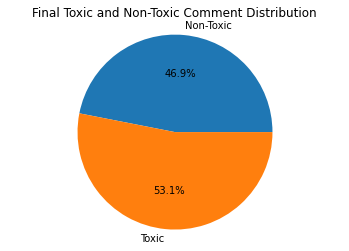

In [9]:
# Gather all samples that have no toxic labels, these can be consider "non-toxic"
non_toxic = train[(train.toxic == 0) &
                  (train.severe_toxic == 0) & 
                  (train.obscene == 0) & 
                  (train.threat == 0) & 
                  (train.insult == 0) & 
                  (train.identity_hate == 0)]

# Gather all samples that are labelled
toxic = train[(train.toxic == 1) |
                  (train.severe_toxic == 1) | 
                  (train.obscene == 1) | 
                  (train.threat == 1) | 
                  (train.insult == 1) | 
                  (train.identity_hate == 1)]

labels = ["Non-Toxic", "Toxic"]
data = [len(non_toxic), len(toxic)]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Final Toxic and Non-Toxic Comment Distribution')
plt.axis('equal')
plt.show()

In [10]:
classes2 = {}

for index in range(1,7):
    classes2.update({train.iloc[:,index].name : np.histogram(train.iloc[:,index], bins=2)[0]})

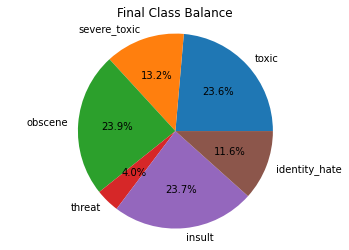

In [11]:
labels = list(classes2.keys())
values = list(classes2.values())
data = [values[x][1] for x in range(0,len(values))]

plt.pie(data,labels=labels,autopct='%1.1f%%')
plt.title('Final Class Balance')
plt.axis('equal')
plt.show()

### Visualisation of Dataset Contents

These visualisations were prepared by Mohamed Hassan

In [12]:
# Remove punctuation
regex_str = "[^a-zA-Z\s]"
train['comment_text'] = train['comment_text'].replace(regex=regex_str, value="")

# Remove extra whitespaces
regex_space = "\s+"
train['comment_text'] = train['comment_text'].replace(regex=regex_space, value=" ")

# Strip whitespaces
train['comment_text'] = train['comment_text'].str.strip()

# Lowercase
train['comment_text'] = train['comment_text'].str.lower()

# Convert comment_text column into a list
comment_list = train['comment_text'].tolist()

In [13]:
comments = [sentence.split() for sentence in comment_list]
tokenised_comment = [word for sentence in comments for word in sentence]

In [14]:
nltk.download('stopwords')

# Remove stopwords, using stopword list from nltk
stopword_list = set(stopwords.words('english'))
removed_stopwords = [word for word in tokenised_comment if word not in stopword_list]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
from collections import Counter

def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common(50)
    x, y=[], []
    for word,count in most:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)

In [16]:
# Gather all samples that have no toxic labels, these can be consider "non-toxic"
non_toxic = train[(train.toxic == 0) &
                  (train.severe_toxic == 0) & 
                  (train.obscene == 0) & 
                  (train.threat == 0) & 
                  (train.insult == 0) & 
                  (train.identity_hate == 0)]

# Gather all samples that are labelled
toxic = train[(train.toxic == 1) |
                  (train.severe_toxic == 1) | 
                  (train.obscene == 1) | 
                  (train.threat == 1) | 
                  (train.insult == 1) | 
                  (train.identity_hate == 1)]

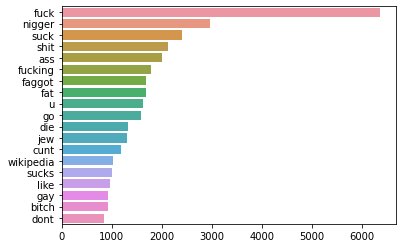

In [17]:
plot_top_non_stopwords_barchart(toxic['comment_text'])   

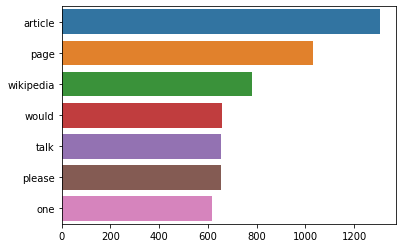

In [18]:
plot_top_non_stopwords_barchart(non_toxic['comment_text'])

### Pre-processing

In this section, the dataset will be pre-processed as per our group's requirements.

The goal is to arrive at a cleaned, stopworded and lemmatised list of comments, each of which is made up of a list of numerical sequences. These sequences represent the frequency ranking of each word, and help with the network in observing patterns in the data, which is one of the best ways to analyse text using a CNN.

The majority of the pre-processing algorithm was prepared by Xin Wei Lam

In [19]:
y_train = train.drop(columns="comment_text")

In [20]:
# Pre-processing functions

# Function to clean comments in train dataset
# Params: 
#   pd dataframe    - @train_dataset: Training dataset
# Output: 
#   2D List         - @comment_list: cleaned comments
def clean_data(train_dataset):
    # Remove punctuation
    regex_str = "[^a-zA-Z\s]"
    train_dataset['comment_text'] = train_dataset['comment_text'].replace(regex=regex_str, value="")

    # Remove extra whitespaces
    regex_space = "\s+"
    train_dataset['comment_text'] = train_dataset['comment_text'].replace(regex=regex_space, value=" ")

    # Strip whitespaces
    train_dataset['comment_text'] = train_dataset['comment_text'].str.strip()

    # Lowercase
    train_dataset['comment_text'] = train_dataset['comment_text'].str.lower()

    return train_dataset['comment_text']

# Function to get NLTK POS Tagger
# Params: 
#   Str - @word: Token
# Output
#   Dict - POS tagger
def nltk_get_wordnet_pos(word):
    
    tag = nltk.pos_tag([word])[0][1][0].upper()

    # Convert NLTK to wordnet POS notations

    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN) # Default to noun if not found

# Function to use NLTK lemmatizer
# Params: 2D List - Tokenized comments with stopwords removed
# Returns: 2D List - lemmatized tokens
def nltk_lemmatize(comment_stop):
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')
    comment_lemma = []
    lemmatizer = WordNetLemmatizer()
    lemmatizer_cache = lru_cache(maxsize=50000)(lemmatizer.lemmatize)

    for comment in comment_stop:
        temp = []
        temp.append([lemmatizer_cache(word, pos=nltk_get_wordnet_pos(word)) for word in comment])
        comment_lemma += temp

    return comment_lemma

# Function to remove NLTK stopwords
# Params: 
#   2D List - @comment_token: cleaned & tokenized comments
# Output:
#   2D List - @comment_stop: cleaned tokens with stopwords removed
def nltk_stopwords(comment_token):
    # Stopwords in English only
    STOP_WORDS = set(stopwords.words('english'))

    # Remove stopwords
    comment_stop = []

    for comment in comment_token:
        
        temp_word = []

        for word in comment:
            
            if word not in STOP_WORDS:
                temp_word.append(word)

        comment_stop.append(temp_word)
    
    return comment_stop

# Function to tokenize comments using NLTK Word Tokenize
# Params: 
#   2D List - @text: cleaned comments
# Output: 
#   2D List - tokenized comments
def nltk_tokenize(text):
    nltk.download("punkt")
    return [word_tokenize(word) for word in text]

def to_sequences(text, num_words, max_len):
    tokenizer = Tokenizer(num_words)
    tokenizer.fit_on_texts(text)
    x_sequences_train = tokenizer.texts_to_sequences(text)
    X_tr = keras.preprocessing.sequence.pad_sequences(x_sequences_train, maxlen=max_len)
    X_tr = np.array(X_tr)
    return X_tr

def preprocess(text):
    text = clean_data(text)
    text = nltk_tokenize(text)
    text = nltk_stopwords(text)
    text = nltk_lemmatize(text)
    #temp_text = to_sequences(text, num_words, max_len)
    return text

In [21]:
x_text_train = preprocess(train)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [22]:
num_words = 20000
max_len = 200

tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(x_text_train)
x_sequences_train = tokenizer.texts_to_sequences(x_text_train)
X_t = keras.preprocessing.sequence.pad_sequences(x_sequences_train, maxlen=max_len)
X_t = np.array(X_t)

In [23]:
val_split = 0.2
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = y_train[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = y_train[-num_validation_samples: ]

### Base Model Definition

This base model has been utilised by each group member in their individual experimentation work. The aim was to facilitate the immediate comparison of every member's experiment results with the base model's results, as well as with the results of most other experiments, where applicable.

This base model was prepared by myself and is defined below:

In [24]:
model = Sequential()

model.add(Embedding(num_words, 128))
model.add(Dropout(0.4))
model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

adam = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss='binary_crossentropy',
            optimizer=adam,
            metrics=['accuracy'])

Design choices such as the model layout, and loss and optimizer functions, were made through researching popular NLP text classification solutions. 

The intent with my experiments is to prove or disprove how efficient some of these modelling choices are, in the context of this dataset.

### Base Model Results

In [25]:
model.fit(x_train,y_train, epochs=EPOCHS, batch_size=60,  validation_data=(x_val, y_val))

Epoch 1/15
96/96 [==============================] - 20s 199ms/step - loss: 0.5992 - accuracy: 0.3814 - val_loss: 0.3495 - val_accuracy: 0.4074
Epoch 2/15
96/96 [==============================] - 18s 192ms/step - loss: 0.4471 - accuracy: 0.4588 - val_loss: 0.2466 - val_accuracy: 0.2335
Epoch 3/15
96/96 [==============================] - 18s 189ms/step - loss: 0.3658 - accuracy: 0.4625 - val_loss: 0.2873 - val_accuracy: 0.2279
Epoch 4/15
96/96 [==============================] - 18s 192ms/step - loss: 0.3471 - accuracy: 0.5184 - val_loss: 0.2693 - val_accuracy: 0.2153
Epoch 5/15
96/96 [==============================] - 18s 191ms/step - loss: 0.3234 - accuracy: 0.5287 - val_loss: 0.2849 - val_accuracy: 0.2167
Epoch 6/15
96/96 [==============================] - 18s 188ms/step - loss: 0.3086 - accuracy: 0.5463 - val_loss: 0.2907 - val_accuracy: 0.2069
Epoch 7/15
96/96 [==============================] - 18s 189ms/step - loss: 0.2993 - accuracy: 0.5535 - val_loss: 0.3110 - val_accuracy: 0.2258

This view of the model results uses accuracy as a metric. With ~56% final average accuracy, it does not appear that this model is a good candidate for predicting toxic comments. 

It should be noted, however, that the algorithm for calculating accuracy only considers predictions as true when all of the classes have been predicted correctly. If even one class has been predicted as not present when it is labelled as present in the given comment, the entire prediction is false.

For this reason, we have opted to use the average precision for each of the classes in order to evaluate this and all following models.

Finally, in order to validate that none of our design choices have caused the model to be overfitted to the training data, the dataset used for calculating this evaluation metric will be the unseen *test* dataset. For the purpose of brevity, the class balancing of this dataset has been omitted.

In [26]:
!pip install pickle5
import pickle5
x_test = pickle5.load(open('data/balanced_test_dataset.pickle', 'rb'))

In [27]:
y_test = x_test.drop(columns="comment_text")
y_test = y_test.to_numpy()

In [28]:
x_test = preprocess(x_test)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [29]:
x_sequences_test = tokenizer.texts_to_sequences(x_test)
X_te = keras.preprocessing.sequence.pad_sequences(x_sequences_test, maxlen=max_len)
X_te = np.array(X_te)

This results calculation and visualisation code is based on Vinal Asodia's and Dennis Ocaka's work

In [30]:
def calculate_metrics(curr_model, test_dataset):
  y_pred = curr_model.predict(test_dataset)
  y_pred = np.array(y_pred)
  y_pred = y_pred.astype(float)

  precision = dict()
  recall = dict()
  average_precision = dict()
  index = 0
  for label in LABELS:
    
    precision[label], recall[label], _ = precision_recall_curve(y_test[:, index],
                                                        y_pred[:, index])
    average_precision[label] = average_precision_score(y_test[:, index], y_pred[:, index])
    index+=1
  return precision, recall, average_precision

In [31]:
precision_base, recall_base, average_precision_base = calculate_metrics(model, X_te)

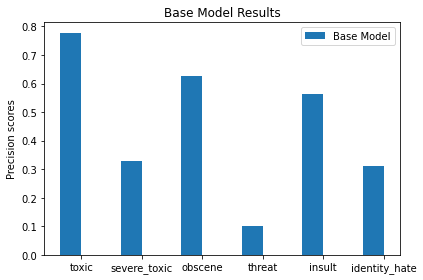

In [32]:
x = np.arange(len(LABELS))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width / 2, average_precision_base.values(), width, label="Base Model")

ax.set_ylabel('Precision scores')
ax.set_title('Base Model Results')
ax.set_xticks(x)
ax.set_xticklabels(LABELS)
ax.legend()

fig.tight_layout()

plt.show()

As can be seen above, the model is best suited towards predicting the most populous classes, such as *toxic*, *obscene*, and *insult*, reaching an average of 68% average precision on each. With these values, it can be concluded that even the base model can be a good classifier for these classes.

However, as the amount of comments labelled in a given class decreases, so does the model's performance in said class. The model only achieved a ~10% average precision score in the *threat* class, which is understandable seeing as it only makes up 5% of the overall dataset.

In [33]:
model.save('base_model.h5')

### Experiment 1: Optimisers - RMSProp

The first experiment will investigate whether the *Adam* function, as used in the Base Model, is the best optimizer function for this project.

The *RMSProp* function will be investigated first.

In [34]:
rmsprop_model = Sequential()

rmsprop_model.add(Embedding(num_words, 128))
rmsprop_model.add(Dropout(0.4))
rmsprop_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
rmsprop_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
rmsprop_model.add(GlobalMaxPooling1D())
rmsprop_model.add(Dense(128, activation="relu"))
rmsprop_model.add(Dropout(0.5))
rmsprop_model.add(Dense(6, activation='sigmoid'))

rmsprop_model.compile(loss='binary_crossentropy',
            optimizer="RMSprop",
            metrics=['accuracy'])

In [35]:
rmsprop_model.fit(x_train,y_train, epochs=EPOCHS, batch_size=60,  validation_data=(x_val, y_val))

Epoch 1/15
96/96 [==============================] - 17s 172ms/step - loss: 0.5880 - accuracy: 0.3087 - val_loss: 0.3001 - val_accuracy: 0.2027
Epoch 2/15
96/96 [==============================] - 16s 171ms/step - loss: 0.4328 - accuracy: 0.4031 - val_loss: 0.2229 - val_accuracy: 0.2195
Epoch 3/15
96/96 [==============================] - 16s 168ms/step - loss: 0.3792 - accuracy: 0.4726 - val_loss: 0.2546 - val_accuracy: 0.2132
Epoch 4/15
96/96 [==============================] - 16s 168ms/step - loss: 0.3605 - accuracy: 0.5071 - val_loss: 0.2501 - val_accuracy: 0.2293
Epoch 5/15
96/96 [==============================] - 16s 167ms/step - loss: 0.3454 - accuracy: 0.5348 - val_loss: 0.2708 - val_accuracy: 0.2090
Epoch 6/15
96/96 [==============================] - 16s 168ms/step - loss: 0.3273 - accuracy: 0.5253 - val_loss: 0.2594 - val_accuracy: 0.2118
Epoch 7/15
96/96 [==============================] - 16s 167ms/step - loss: 0.3067 - accuracy: 0.5338 - val_loss: 0.3161 - val_accuracy: 0.2482

In [36]:
precision, recall, average_precision_rms = calculate_metrics(rmsprop_model, X_te)

In [37]:
def plot_against_base(dict_values, base_label, curr_label):
  fig, ax = plt.subplots()
  ax.bar(x - width / 2, average_precision_base.values(), width, label=base_label)
  ax.bar(x + width / 2, dict_values, width, label=curr_label)

  title = "{0} vs {1}"
  ax.set_ylabel('Precision scores')
  ax.set_title(title.format(base_label, curr_label))
  ax.set_xticks(x)
  ax.set_xticklabels(LABELS)
  ax.legend()

  fig.tight_layout()

  plt.show()

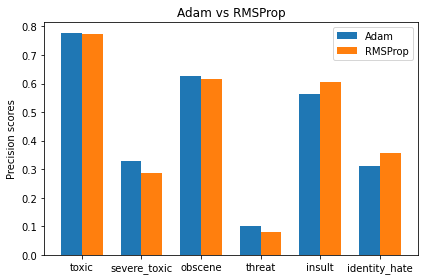

In [38]:
plot_against_base(average_precision_rms.values(), "Adam", "RMSProp")

While the overall accuracy appears to remain the same as the Base Model, the RMSProp optimizer function appears to provide about the same average precision values in the most populous classes, at the cost of lower values in the least populous classes.

Unless we were interested in extracting only one of the heads of this model, e.g. the *insult* or the *identity_hate* classification head, these results are overall worse, as the goal should be increasing the model's performance in its weakest areas.

In [39]:
rmsprop_model.save('models/RMSProp_model.h5')

### Experiment 1: Optimisers - Nadam

The second optimizer I have chosen to experiment with is the *Nadam* optimizer function.

In [40]:
nadam_model = Sequential()

nadam_model.add(Embedding(num_words, 128))
nadam_model.add(Dropout(0.4))
nadam_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
nadam_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
nadam_model.add(GlobalMaxPooling1D())
nadam_model.add(Dense(128, activation="relu"))
nadam_model.add(Dropout(0.5))
nadam_model.add(Dense(6, activation='sigmoid'))

nadam_model.compile(loss='binary_crossentropy',
            optimizer="Nadam",
            metrics=['accuracy'])

In [41]:
nadam_model.fit(x_train,y_train, epochs=EPOCHS, batch_size=60,  validation_data=(x_val, y_val))

Epoch 1/15
96/96 [==============================] - 19s 184ms/step - loss: 0.6003 - accuracy: 0.2261 - val_loss: 0.1985 - val_accuracy: 0.0217
Epoch 2/15
96/96 [==============================] - 18s 183ms/step - loss: 0.4227 - accuracy: 0.4481 - val_loss: 0.2594 - val_accuracy: 0.2223
Epoch 3/15
96/96 [==============================] - 17s 175ms/step - loss: 0.3690 - accuracy: 0.4972 - val_loss: 0.2955 - val_accuracy: 0.2391
Epoch 4/15
96/96 [==============================] - 17s 182ms/step - loss: 0.3384 - accuracy: 0.5060 - val_loss: 0.2749 - val_accuracy: 0.2195
Epoch 5/15
96/96 [==============================] - 17s 178ms/step - loss: 0.3260 - accuracy: 0.5419 - val_loss: 0.2666 - val_accuracy: 0.2034
Epoch 6/15
96/96 [==============================] - 17s 182ms/step - loss: 0.3178 - accuracy: 0.5511 - val_loss: 0.4086 - val_accuracy: 0.2363
Epoch 7/15
96/96 [==============================] - 17s 179ms/step - loss: 0.3024 - accuracy: 0.5655 - val_loss: 0.3081 - val_accuracy: 0.2041

In [42]:
precision, recall, average_precision_nadam = calculate_metrics(nadam_model, X_te)

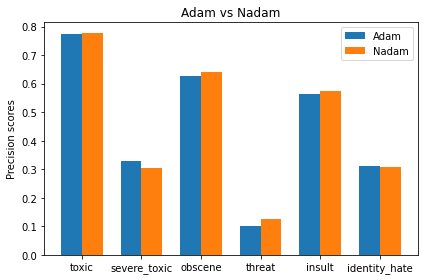

In [43]:
plot_against_base(average_precision_nadam.values(), "Adam", "Nadam")

These precision scores seem to indicate that the highs of the *RMSProp* and *Binary Cross-Entropy* functions have been retained with *Nadam*, without incurring the cost of lowered performance in the least populous classes. Instead, it appears that performance has generally increased in these classes, with an increase to 13% in the most troublesome class, *threat*.

These results show that *Nadam* surpasses both the *Adam* and *RMSProp* functions, as the superior optimizer function choice. 

In [44]:
nadam_model.save('models/Nadam_model.h5')

### Experiment 2: Loss Functions - Categorical Crossentropy

In this series of experiments, I opted to look into the original choice of *Binary Cross-Entropy* as the Base Model's loss function. As the name would suggest, *Binary Cross-Entropy* is a loss function intended for use in models with the goal of binary classification. However, as observed in the Base Model Results section, a model with this loss function can provide relatively precise results, even when implemented in a multi-class classification problem such as ours.

With these experiments, my aim is to investigate whether the unintuitive choice of *Binary Cross-Entropy* is also the best choice of loss function for this project.

Finally, it should be noted that for this and all following experiments, I have chosen to not use any previous findings of better model design choices. I have instead reverted all design choices that are not relevant to the current experiment to be equal to the choices made in the Base Model. This is in order to be able to accurately compare the results of each experiment with all other experiments' results. It is not feasible, within the scope of this project, to experiment with all permutations of models with the best results in each experiment to see which combination of design choices provides the best results. For this reason, I opted to compare all experiment results to each other accurately, and provide the best single model design choice change from the Base Model to my team.

In [45]:
cat_cross_model = Sequential()

cat_cross_model.add(Embedding(num_words, 128))
cat_cross_model.add(Dropout(0.4))
cat_cross_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
cat_cross_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
cat_cross_model.add(GlobalMaxPooling1D())
cat_cross_model.add(Dense(128, activation="relu"))
cat_cross_model.add(Dropout(0.5))
cat_cross_model.add(Dense(6, activation='sigmoid'))

cat_cross_model.compile(loss='categorical_crossentropy',
            optimizer=adam,
            metrics=['accuracy'])

In [46]:
cat_cross_model.fit(x_train,y_train, epochs=EPOCHS, batch_size=60,  validation_data=(x_val, y_val))

Epoch 1/15
96/96 [==============================] - 19s 191ms/step - loss: 142444.5053 - accuracy: 0.2730 - val_loss: 65623.2500 - val_accuracy: 0.9944
Epoch 2/15
96/96 [==============================] - 18s 183ms/step - loss: 10343096.3222 - accuracy: 0.2479 - val_loss: 883108.8750 - val_accuracy: 0.9944
Epoch 3/15
96/96 [==============================] - 18s 186ms/step - loss: 64485142.1031 - accuracy: 0.2640 - val_loss: 4347637.0000 - val_accuracy: 0.9944
Epoch 4/15
96/96 [==============================] - 18s 186ms/step - loss: 163237174.7629 - accuracy: 0.2758 - val_loss: 8458580.0000 - val_accuracy: 0.9944
Epoch 5/15
96/96 [==============================] - 18s 187ms/step - loss: 270228954.5567 - accuracy: 0.2658 - val_loss: 13885460.0000 - val_accuracy: 0.9944
Epoch 6/15
96/96 [==============================] - 18s 189ms/step - loss: 353428043.2165 - accuracy: 0.2651 - val_loss: 16153337.0000 - val_accuracy: 0.0042
Epoch 7/15
96/96 [==============================] - 18s 187ms/st

As can be seen here, the loss skyrockets when using *Categorical Cross-Entropy*. After performing additional research, the reason this occurs is that we have 6 possible hot classes, so *Categorical Cross-Entropy* does not apply in the case of  multi-class problems, only in multi-label classification problems. Since this choice of loss function is not applicable, I have performed another experiment with a loss function that can produce accurate results with our model.

I did not cut this experiment altogether, however, as I find it interesting that in spite of the loss being basically unusable for the model, it was still somehow able to learn something instead of randomly guessing, as seen in the evaluation below:

In [47]:
precision, recall, average_precision_cat = calculate_metrics(cat_cross_model, X_te)

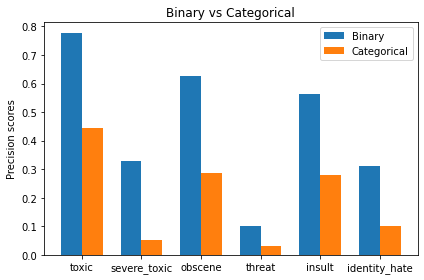

In [48]:
plot_against_base(average_precision_cat.values(), "Binary", "Categorical")

Obviously, when compared to a loss function that is fit to task, the *Categorical Cross-Entropy* loss function cannot match the level of precision. 
However, it is interesting to observe that the model was indeed learning through some mechanism, which is something that can be verified in two ways: Firstly, the average accuracy of the model is ~25%, which is much higher than one would get by randomly guessing 1 of the 30 possible permutations of 6 binary digits can take. Secondly, the relative average precision of each class is very close to the same for the *Binary Cross-Entropy* model. As this spread of average precisions in the Base Model is due to the dataset's class-balancing, we can see that this *Categorical Cross-Entropy* model was indeed learning from the data as well.

### Experiment 2: Loss Functions - Poisson

In [49]:
psn_model = Sequential()

psn_model.add(Embedding(num_words, 128))
psn_model.add(Dropout(0.4))
psn_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
psn_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
psn_model.add(GlobalMaxPooling1D())
psn_model.add(Dense(128, activation="relu"))
psn_model.add(Dropout(0.5))
psn_model.add(Dense(6, activation='sigmoid'))

psn_model.compile(loss='poisson',
            optimizer=adam,
            metrics=['accuracy'])

In [50]:
psn_model.fit(x_train,y_train, epochs=EPOCHS, batch_size=60,  validation_data=(x_val, y_val))

Epoch 1/15
96/96 [==============================] - 19s 189ms/step - loss: 0.6610 - accuracy: 0.3078 - val_loss: 0.2055 - val_accuracy: 0.2111
Epoch 2/15
96/96 [==============================] - 18s 184ms/step - loss: 0.5615 - accuracy: 0.3423 - val_loss: 0.1980 - val_accuracy: 0.2125
Epoch 3/15
96/96 [==============================] - 18s 189ms/step - loss: 0.5406 - accuracy: 0.4276 - val_loss: 0.2041 - val_accuracy: 0.2048
Epoch 4/15
96/96 [==============================] - 18s 186ms/step - loss: 0.5186 - accuracy: 0.4585 - val_loss: 0.2178 - val_accuracy: 0.2041
Epoch 5/15
96/96 [==============================] - 18s 186ms/step - loss: 0.5102 - accuracy: 0.5188 - val_loss: 0.2189 - val_accuracy: 0.1992
Epoch 6/15
96/96 [==============================] - 18s 186ms/step - loss: 0.5085 - accuracy: 0.5225 - val_loss: 0.2321 - val_accuracy: 0.1985
Epoch 7/15
96/96 [==============================] - 18s 187ms/step - loss: 0.5047 - accuracy: 0.5331 - val_loss: 0.2454 - val_accuracy: 0.2216

In [51]:
precision, recall, average_precision_psn = calculate_metrics(psn_model, X_te)

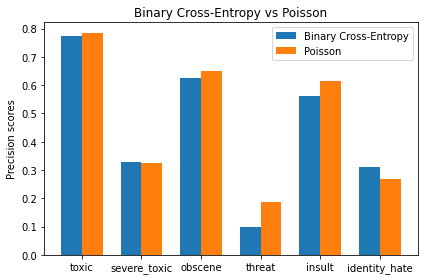

In [52]:
plot_against_base(average_precision_psn.values(), "Binary Cross-Entropy", "Poisson")

Looking at the chart, with only the exception of the *identity_hate* class, the model using the *Poisson* loss function is an increase in all classes. The *threat* class's precision score specifically has increased to over 20% from 10%.

It is apparent that the *Poisson* loss function is more suited to this project than the *Binary Cross-Entropy* loss function.

In [53]:
psn_model.save('models/Poisson_model.h5')

### Experiment 3: Activation Functions - Softmax

For this experiment, I decided to investigate the effect of an often overlooked design choice, the output activation function. This choice is usually defaulted to the *sigmoid* function in most if not all basic approaches using CNNs. The aim of this experiment is to prove or disprove that collective empirical wisdom in the case of our approach to this dataset.

For this first experiment with this setup, I chose the *softmax* function, as it appears to be the second most popular output activation function choice, although it is much less popular than the *sigmoid* function.

In [54]:
softmax_model = Sequential()

softmax_model.add(Embedding(num_words, 128))
softmax_model.add(Dropout(0.4))
softmax_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
softmax_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
softmax_model.add(GlobalMaxPooling1D())
softmax_model.add(Dense(128, activation="relu"))
softmax_model.add(Dropout(0.5))
softmax_model.add(Dense(6, activation='softmax'))

softmax_model.compile(loss='binary_crossentropy',
            optimizer=adam,
            metrics=['accuracy'])

In [55]:
softmax_model.fit(x_train,y_train, epochs=EPOCHS, batch_size=60,  validation_data=(x_val, y_val))

Epoch 1/15
96/96 [==============================] - 19s 186ms/step - loss: 0.5548 - accuracy: 0.3728 - val_loss: 0.2487 - val_accuracy: 0.2111
Epoch 2/15
96/96 [==============================] - 18s 184ms/step - loss: 0.3833 - accuracy: 0.4547 - val_loss: 0.2618 - val_accuracy: 0.2328
Epoch 3/15
96/96 [==============================] - 18s 186ms/step - loss: 0.3388 - accuracy: 0.5537 - val_loss: 0.2571 - val_accuracy: 0.1978
Epoch 4/15
96/96 [==============================] - 18s 188ms/step - loss: 0.3158 - accuracy: 0.5557 - val_loss: 0.3043 - val_accuracy: 0.2251
Epoch 5/15
96/96 [==============================] - 18s 188ms/step - loss: 0.3084 - accuracy: 0.5675 - val_loss: 0.3081 - val_accuracy: 0.2237
Epoch 6/15
96/96 [==============================] - 18s 184ms/step - loss: 0.2885 - accuracy: 0.5862 - val_loss: 0.3254 - val_accuracy: 0.2167
Epoch 7/15
96/96 [==============================] - 18s 183ms/step - loss: 0.2658 - accuracy: 0.5771 - val_loss: 0.3537 - val_accuracy: 0.2202

In [56]:
precision, recall, average_precision_softmax = calculate_metrics(softmax_model, X_te)

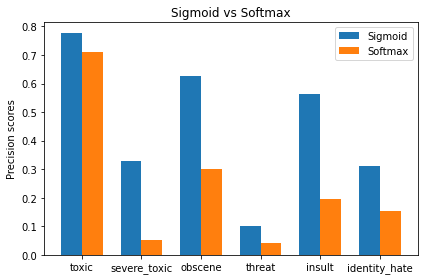

In [57]:
plot_against_base(average_precision_softmax.values(), "Sigmoid", "Softmax")

It appears these results are lower than the Base Model's results using the *sigmoid* function in most categories, with significant precision losses in all but the most popular class, *toxic*, which appears to remain relatively equal to the Base Model's results.

After deciding to look into the above results further, it appears that the above is the definitive reason that the *softmax* function is not applicable to this problem. When used as the output activation function, the output of the network can only add up to a maximum value of 1. When 6 output classes are used, such as in our project, the resulting predictions will all either round down to 0, making the model much more likely to predict a comment is non-toxic, or perhaps round up to 1 in a single class.

Clearly, the *softmax* function is verifiably inferior to the *sigmoid* function when applied to multi-class classification problems.

In [58]:
y_pred = softmax_model.predict(X_te)
y_pred = np.array(y_pred)
y_pred = y_pred.astype(float)

temp_index = 64

print("Raw predictions:")
print(y_pred[temp_index])
print("Rounded predictions:")
print(y_pred[temp_index].round())
print("True:")
print(y_test[temp_index])

Raw predictions:
[0.36423185 0.12406462 0.21773395 0.02477345 0.20900513 0.06019095]
Rounded predictions:
[0. 0. 0. 0. 0. 0.]
True:
[1 0 0 0 0 1]


### Experiment 3: Activation Functions - Tanh

In [59]:
tanh_model = Sequential()

tanh_model.add(Embedding(num_words, 128))
tanh_model.add(Dropout(0.4))
tanh_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
tanh_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
tanh_model.add(GlobalMaxPooling1D())
tanh_model.add(Dense(128, activation="relu"))
tanh_model.add(Dropout(0.5))
tanh_model.add(Dense(6, activation='tanh'))

tanh_model.compile(loss='binary_crossentropy',
            optimizer=adam,
            metrics=['accuracy'])

In [60]:
tanh_model.fit(x_train,y_train, epochs=EPOCHS, batch_size=60,  validation_data=(x_val, y_val))

Epoch 1/15
96/96 [==============================] - 19s 189ms/step - loss: 0.8655 - accuracy: 0.2714 - val_loss: 0.2173 - val_accuracy: 0.9306
Epoch 2/15
96/96 [==============================] - 18s 185ms/step - loss: 0.4911 - accuracy: 0.2896 - val_loss: 0.2830 - val_accuracy: 0.2518
Epoch 3/15
96/96 [==============================] - 18s 189ms/step - loss: 0.4715 - accuracy: 0.3974 - val_loss: 0.2783 - val_accuracy: 0.3254
Epoch 4/15
96/96 [==============================] - 18s 184ms/step - loss: 0.3988 - accuracy: 0.3888 - val_loss: 0.2603 - val_accuracy: 0.2539
Epoch 5/15
96/96 [==============================] - 18s 183ms/step - loss: 0.3701 - accuracy: 0.3884 - val_loss: 0.3055 - val_accuracy: 0.2272
Epoch 6/15
96/96 [==============================] - 18s 185ms/step - loss: 0.3607 - accuracy: 0.3963 - val_loss: 0.2438 - val_accuracy: 0.1788
Epoch 7/15
96/96 [==============================] - 18s 183ms/step - loss: 0.3425 - accuracy: 0.4134 - val_loss: 0.2875 - val_accuracy: 0.2174

In [61]:
precision, recall, average_precision_tanh = calculate_metrics(tanh_model, X_te)

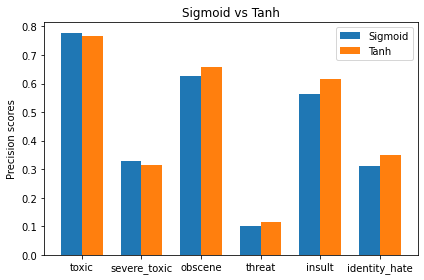

In [62]:
plot_against_base(average_precision_tanh.values(), "Sigmoid", "Tanh")

When using the *tanh* output layer activation function, it seems that the model's precision on the more generically applicable functions such as *toxic* has decreased slightly, but major increases can be observed in almost all other classes.

As the overall precision of the model appears to have increased significantly, the suggested output layer activation function seems to be *tanh* instead of the initial *sigmoid*.

In [73]:
tanh_model.save('models/Tanh_model.h5')

### Experiment 4: Pretrained Word Embeddings

For the final experiment setup, I chose the setup with the maximum likelihood of greatly increasing the performance of our model in all metrics. The approach here is to transfer pre-trained word embedding weights to our embedding layer, in order to avoid training these weights from scratch, while also training all other weights in the network at the same time.

The weights used in this experiment were acquired here [https://nlp.stanford.edu/projects/glove/], using the smallest set of vectors, the 6B token version. This is due to file size constraints, as even the smallest set with the smallest dimensions is as large as 167 MB.

In [74]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('data/glove.6B.50d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


The first step in using these pretrained weights in our model, is to create an embedding matrix by mapping each word in our current corpus to it's matching embedding weight vector.

In [64]:
vocab_len = len(tokenizer.word_index) + 1

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_len, 50))

print(embedding_matrix.shape)

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

(23457, 50)


In [65]:
embed_model = Sequential()

embed_model.add(Embedding(vocab_len,50,weights=[embedding_matrix],input_length=max_len,trainable=True))
embed_model.add(Dropout(0.4))
embed_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
embed_model.add(Conv1D(128, 7, padding="valid", activation="relu", strides=3))
embed_model.add(GlobalMaxPooling1D())
embed_model.add(Dense(128, activation="relu"))
embed_model.add(Dropout(0.5))
embed_model.add(Dense(6, activation='sigmoid'))

embed_model.compile(loss='binary_crossentropy',
            optimizer=adam,
            metrics=['accuracy'])

In [66]:
embed_model.fit(x_train,y_train, epochs=EPOCHS, batch_size=60,  validation_data=(x_val, y_val))

Epoch 1/15
96/96 [==============================] - 11s 101ms/step - loss: 0.5390 - accuracy: 0.3413 - val_loss: 0.3077 - val_accuracy: 0.2686
Epoch 2/15
96/96 [==============================] - 10s 101ms/step - loss: 0.4252 - accuracy: 0.4716 - val_loss: 0.2692 - val_accuracy: 0.2230
Epoch 3/15
96/96 [==============================] - 9s 99ms/step - loss: 0.3937 - accuracy: 0.4858 - val_loss: 0.2552 - val_accuracy: 0.2139
Epoch 4/15
96/96 [==============================] - 9s 99ms/step - loss: 0.3877 - accuracy: 0.5056 - val_loss: 0.2713 - val_accuracy: 0.2279
Epoch 5/15
96/96 [==============================] - 9s 96ms/step - loss: 0.3637 - accuracy: 0.4964 - val_loss: 0.2771 - val_accuracy: 0.2342
Epoch 6/15
96/96 [==============================] - 9s 97ms/step - loss: 0.3488 - accuracy: 0.5225 - val_loss: 0.2830 - val_accuracy: 0.2216
Epoch 7/15
96/96 [==============================] - 9s 99ms/step - loss: 0.3387 - accuracy: 0.5175 - val_loss: 0.2736 - val_accuracy: 0.2167
Epoch 8/1

In [67]:
precision, recall, average_precision_embed = calculate_metrics(embed_model, X_te)

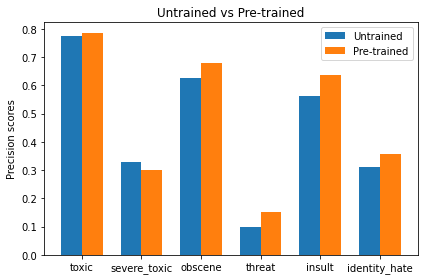

In [68]:
plot_against_base(average_precision_embed.values(), "Untrained", "Pre-trained")

Although the precision increases in each class were not as high as expected, it is clear to see that using pre-trained word embeddings increases the performance of the model across all classes, with the most major increases being seen in the least populous classes.

These results are as expected, seeing as the biggest factor contributing to the low performance in these less-populated classes is that the network does not have enough data to train on such classes. When pre-trained weights are introduced, the amount of training the network needs to do as a base is massively reduced, so more quality learning can take place for these classes.

In [70]:
embed_model.save('models/Embed_model.h5')

### Conclusion

In conclusion, each experiment setup achieved its goal of investigating alternative model design choices, with everything else equal. Where some experiments yielded worse results than the Base Model, these worse results can be used to inform future design decisions for the group implementation fo this project, as well as future projects using similar datasets and models.

I believe that namely, the results of Experiment 2 and 4 are the most likely candidates of working together with everyone else's experimental findings, in order to increase the final model's performance in classifying toxic comments. These experiments showed that using pre-trained word embeddings as well as the *Nadam* optimizer should definitely improve our results for the group implementation.

Finally, it is clear that, in future, anyone aiming to improve a similar model's performance in detecting toxic comments using the Toxic Comment Classification Challenge dataset should first focus on either increasing the quality of the less populated classes such as *threat*, or directly introducing *threat*-rated comments from the test dataset into the training dataset, to increase their amount. 